## Getting Data

In [0]:
# !pip install kaggle

In [0]:
!mkdir .kaggle

In [0]:
!mkdir ~/.kaggle

In [0]:
import json
token = {'username':'aishakhatun','key':'cd63cc254a0b0f5f8471f7b6895edc7c'}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [5]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
# !kaggle datasets list

In [8]:
!kaggle datasets download -d snap/amazon-fine-food-reviews -p /content

 98% 245M/251M [00:01<00:00, 168MB/s]
100% 251M/251M [00:01<00:00, 173MB/s]


In [9]:
!unzip \*.zip

Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


## EDA

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from torchtext import data, vocab
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import spacy
import torchtext
from torchtext.data import Field, BucketIterator, TabularDataset
en = spacy.load('en')
import numpy as np
import pandas as pd
import os
import string
import re
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
import torch.utils.data
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from collections import Counter
import pickle

Using TensorFlow backend.


In [0]:
df = pd.read_csv('Reviews.csv')

In [48]:
df = df[['Score', 'Text']]
df.head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [49]:
df.Score.unique()

array([5, 1, 4, 2, 3])

Stuck at this for HOURS. Cuda gives all kinds of weird errors, but the problem is my labels we not from 0-4

In [0]:
df.Score=df.Score-1

In [51]:
df.Score.unique()

array([4, 0, 3, 1, 2])

In [52]:
df.Score.value_counts()

4    363122
3     80655
0     52268
2     42640
1     29769
Name: Score, dtype: int64

In [53]:
df.dtypes

Score     int64
Text     object
dtype: object

In [54]:
df.shape

(568454, 2)

In [0]:
df = df.dropna().reset_index(drop=True)

In [56]:
df.shape

(568454, 2)

In [21]:
# sm = pd.DataFrame()
# for i in range(5):
#   x=df[df['Score']==i].iloc[:10]
#   sm = sm.append(x, ignore_index = True)

# len(sm)

50

In [0]:
# df = sm

## Tokenization

In [0]:
### All tokenizations combined
re_punc = re.compile("([\'!\"#$%&()*+,-./:;<=>?@[\]^_`{|}~\\\])") # add spaces around punctuation
## () for capturing group, [] for one of the groups in the braces
re_apos = re.compile(r"n ' t ")    # n't
re_bpos = re.compile(r" ' s ")     # 's
re_mult_space = re.compile(r"  *") # replace multiple spaces with just one
replacements = {'\t':' ','\n':' ','\r':' ','\x0b':' ','\x0c':' '}

def simple_toks(sent):
    sent = "".join([replacements.get(c,c) for c in sent])
    sent = re_punc.sub(r" \1 ", sent) # \1 is the group that we have captured
    sent = re_apos.sub(r" n't ", sent)
    sent = re_bpos.sub(r" 's ", sent)
    sent = re_mult_space.sub(' ', sent)
    ret = ['xbos']
    for w in sent.split():
        if w.isupper():
            ret.append('xwup')
        elif w[0].isupper():
            ret.append('xup')
        ret.append(w.lower())
    return ret

## en.tokenizer(text)
## implement !!! as 3*!

In [58]:
train, valid = train_test_split(df, test_size=0.2); len(train), len(valid)

(454763, 113691)

In [0]:
train.to_csv("train.csv", index=False)
valid.to_csv("valid.csv", index=False)

In [0]:
TEXT = Field(sequential=True, tokenize=simple_toks,lower=True, unk_token='xunk' , pad_token='xunk')
LABEL = Field(sequential=False, use_vocab=False)

In [0]:
data_fields = [('Score', LABEL), ('Text', TEXT)]

Takes some time

In [0]:
train_ds,valid_ds = data.TabularDataset.splits(path='./', train='train.csv', validation='valid.csv', format='csv', fields=data_fields,  skip_header=True)

In [0]:
TEXT.build_vocab(train_ds, vectors="glove.6B.100d", max_size=60000 , min_freq=5)

In [64]:
len(TEXT.vocab.itos) , len(TEXT.vocab.stoi)

(39298, 39298)

In [65]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [0]:
batch_size=32

In [0]:
train_iter = BucketIterator(train_ds, batch_size=batch_size, sort_key=lambda x: len(x.Text), shuffle=True, device=device, sort_within_batch=False)

In [0]:
valid_iter = BucketIterator(valid_ds, batch_size=batch_size, sort_key=lambda x: len(x.Text), shuffle=False, device=device, sort_within_batch=False)

In [0]:
#embedding = nn.Embedding(n_embed, embed_dim).from_pretrained(TEXT.vocab.vectors)
#OR
#self.encoder_embedding_layer.weight.data.copy_(self.pre_trained_vector.weight.data)

In [0]:
# TEXT.vocab.vectors.shape

In [0]:
# len(TEXT.vocab)

In [0]:
# TEXT.vocab.vectors[:5,:10]

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

class SimpleLSTMBaseline(nn.Module):
    def __init__(self, hidden_dim, emb_dim=100, num_linear=1):
        super().__init__()
        self.embedding = nn.Embedding(len(TEXT.vocab), emb_dim).from_pretrained(TEXT.vocab.vectors)
        self.encoder = nn.LSTM(emb_dim, hidden_dim, num_layers=1)
        self.linear_layers = []
        for _ in range(num_linear - 1):
            self.linear_layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.linear_layers = nn.ModuleList(self.linear_layers)
        self.predictor = nn.Linear(hidden_dim, 5)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
    def forward(self, seq):
        hdn, _ = self.encoder(self.embedding(seq))
        feature = hdn[-1, :, :]
        for layer in self.linear_layers:
          feature = self.act(layer(feature))#dropout
        preds = self.predictor(feature)
        return preds

In [0]:
em_sz = 100
nh = 128
nl = 3
model = SimpleLSTMBaseline(nh, emb_dim=em_sz, num_linear=nl).to(device)

In [0]:
# model

In [0]:
error = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [0]:
loss_list = []
iteration_list = []
accuracy_list = []
train_loss_list = []
train_acc_list = []
count=0
num_epochs=5

In [43]:
# tmp = BucketIterator(valid_ds, batch_size=batch_size, sort_key=lambda x: len(x.Text), shuffle=False, device='cpu', sort_within_batch=False)
# print(tmp.device,valid_iter.device)
# it = iter(tmp)
# it2 = iter(valid_iter)

cpu cuda


In [44]:
# x = next(it2)
# x.Text.shape, x.Score.shape

(torch.Size([255, 10]), torch.Size([10]))

In [0]:
def trainIt():
  
  global loss_list 
  global iteration_list 
  global accuracy_list
  global train_loss_list 
  global train_acc_list 
  global count

  for epoch in range(1):
      train_loss=0
      train_total=0
      for X in train_iter:
        
          model.train()
          
          txt,lbl = X.Text, X.Score
          
          bs=txt.shape[1]
          
          txt = Variable(txt)
          lbl = Variable(lbl)
          
          opt.zero_grad()
          
          outputs = model(txt)
          
          loss = error(outputs, lbl)
  #         print(outputs.shape, lbl.shape)
          
          loss.backward()
          opt.step()
          
          count+=1
          train_loss+=loss.data
          train_total+=bs
          
          if count%500==0: #500
              with torch.no_grad():
                  model.eval()
                  validation_loss=0
                  total=0
                  correct=0
                  for X in valid_iter:
                    
                      txt,lbl = X.Text, X.Score
                      
                      bs=txt.shape[1]
                      
                      txt = Variable(txt)
                      lbl = Variable(lbl)
                      
                      outputs = model(txt)
                      valid_loss = error(outputs, lbl)
                      
                      ##loss
                      validation_loss+=valid_loss.data
                      ##accuracy:
                      prediction=torch.max(outputs.data, 1)[1]
                      total+=bs
                      correct+=(prediction==lbl).sum().item()
                      
                  loss_list.append(validation_loss/total)
                  accuracy_list.append(100*correct/float(total))
                  iteration_list.append(count)
                  train_loss_list.append(train_loss/train_total)
                  train_loss=0
                  train_total=0

                  if count%2000==0: #2000
                      print('Iteration/Epoch: {}/{}  trainloss: {} Loss: {}  Accuracy: {} %'.format(count,epoch+1,train_loss_list[-1],loss_list[-1], accuracy_list[-1]))

Epoch 1
```
Iteration/Epoch: 2000/1  trainloss: 0.035509705543518066 Loss: 0.035484135150909424  Accuracy: 63.74559111978961 %
Iteration/Epoch: 4000/1  trainloss: 0.03529617190361023 Loss: 0.03542999550700188  Accuracy: 63.783412935060824 %
Iteration/Epoch: 6000/1  trainloss: 0.03524688631296158 Loss: 0.03536951541900635  Accuracy: 63.78517208925948 %
Iteration/Epoch: 8000/1  trainloss: 0.035695310682058334 Loss: 0.035432081669569016  Accuracy: 63.78693124345815 %
Iteration/Epoch: 10000/1  trainloss: 0.03554362803697586 Loss: 0.03538733720779419  Accuracy: 63.792208706054126 %
Iteration/Epoch: 12000/1  trainloss: 0.03520361706614494 Loss: 0.03533337637782097  Accuracy: 63.81331855643806 %
Iteration/Epoch: 14000/1  trainloss: 0.035062387585639954 Loss: 0.035336680710315704  Accuracy: 63.824753058729364 %
```

In [79]:
trainIt() #Epoch 2

Iteration/Epoch: 16000/1  trainloss: 0.033413324505090714 Loss: 0.033619705587625504  Accuracy: 63.83530798392133 %
Iteration/Epoch: 18000/1  trainloss: 0.03482650965452194 Loss: 0.0346444770693779  Accuracy: 63.87312979919255 %
Iteration/Epoch: 20000/1  trainloss: 0.03457863628864288 Loss: 0.03432739898562431  Accuracy: 63.837946715219324 %
Iteration/Epoch: 22000/1  trainloss: 0.033574603497982025 Loss: 0.03385340794920921  Accuracy: 63.926784002251715 %
Iteration/Epoch: 24000/1  trainloss: 0.02699345536530018 Loss: 0.026961319148540497  Accuracy: 68.25430333095848 %
Iteration/Epoch: 26000/1  trainloss: 0.025221334770321846 Loss: 0.025146301835775375  Accuracy: 69.68537527156943 %
Iteration/Epoch: 28000/1  trainloss: 0.024634061381220818 Loss: 0.02455015294253826  Accuracy: 70.27733065941895 %


In [83]:
trainIt() #Epoch 3

Iteration/Epoch: 30000/1  trainloss: 0.023646045476198196 Loss: 0.02354186773300171  Accuracy: 71.40670765495949 %
Iteration/Epoch: 32000/1  trainloss: 0.02262687310576439 Loss: 0.02247110940515995  Accuracy: 73.01281543833724 %
Iteration/Epoch: 34000/1  trainloss: 0.02178291045129299 Loss: 0.021608181297779083  Accuracy: 73.58190182160418 %
Iteration/Epoch: 36000/1  trainloss: 0.021073248237371445 Loss: 0.02167496457695961  Accuracy: 73.48338918647914 %
Iteration/Epoch: 38000/1  trainloss: 0.02059796452522278 Loss: 0.020859623327851295  Accuracy: 74.7851632934885 %
Iteration/Epoch: 40000/1  trainloss: 0.020663918927311897 Loss: 0.020896395668387413  Accuracy: 75.05431388588367 %
Iteration/Epoch: 42000/1  trainloss: 0.020461304113268852 Loss: 0.020306391641497612  Accuracy: 75.41669965080789 %


In [0]:
trainIt() #Epoch 4

In [84]:
len(iteration_list), len(train_loss_list), len(accuracy_list), len(loss_list)

(85, 85, 85, 85)

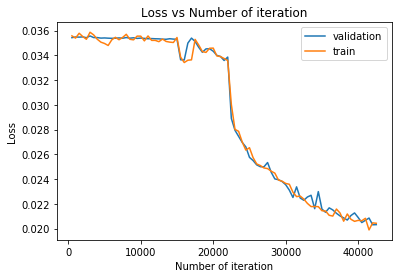

In [85]:
# visualization loss 
plt.plot(iteration_list,loss_list,label='validation')
plt.plot(iteration_list,train_loss_list,label='train')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.title("Loss vs Number of iteration")
plt.savefig('loss.png')
plt.show()

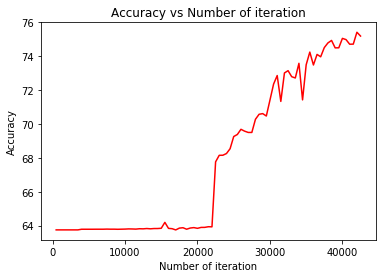

In [86]:
# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of iteration")
plt.savefig('acc.png')
plt.show()